# White Mountain, AK visualization with Google Earth Engine

In [1]:
%matplotlib widget
import ee
import geemap

In [2]:
import sys
sys.path.append('../')

In [3]:
from coastal.gis import dist_latlon2meters
from coastal.plot import plot_from_oa_url

## Google Earth Engine Authentication and Initialization
GEE requires you to authenticate your access, so if `ee.Initialize()` does not work you first need to run `ee.Authenticate()`. This gives you a link at which you can use your google account that is associated with GEE to get an authorization code. Copy the authorization code into the input field and hit *enter* to complete authentication. 

In [4]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Create the USACE Topobathy image collection

Data are from https://chs.coast.noaa.gov/htdata/raster2/elevation/ and are stored as an imageCollection [here](https://code.earthengine.google.com/?asset=projects/uaf-coastal-mapping/assets/USACE_AK_DEM)

In [5]:
topobathyColl = ee.ImageCollection('projects/uaf-coastal-mapping/assets/USACE_AK_DEM')
print('Number of DEMs in the collection (all of AK 2019): ', topobathyColl.size().getInfo())

Number of DEMs in the collection (all of AK 2019):  1147


## Select by geographic region of interest

Specify region of interest from geojson file

In [6]:
fn = 'data/whitemountain.geojson' # a geojson for white mountain, AK. You could also use a shapefile, etc. 
aoi = geemap.geojson_to_ee(fn)

We can subset our topobathy layer based on this region.

In [7]:
whiteMtn = topobathyColl.filterBounds(aoi)
print('Number of White Mountain area DEMs: ', whiteMtn.size().getInfo())

Number of White Mountain area DEMs:  456


## Example ICESat-2 track from our region

See the OpenAltimetry_example notebook for how to create this image and get tracks. We will look at the `gt1l` track.

In [8]:
%%capture
# how to get this url is described in the OpenAltimetry_example notebook
url = 'http://openaltimetry.org/data/api/icesat2/atl06?date=2019-11-01&minx=-163.22047900505012&miny=64.27523261959732&maxx=-162.71950245931393&maxy=64.77401189132661&trackId=541&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
myplot, mydata = plot_from_oa_url(url=url, gtx='gt1l', title='White Mountain ICE-Sat2 from OA')


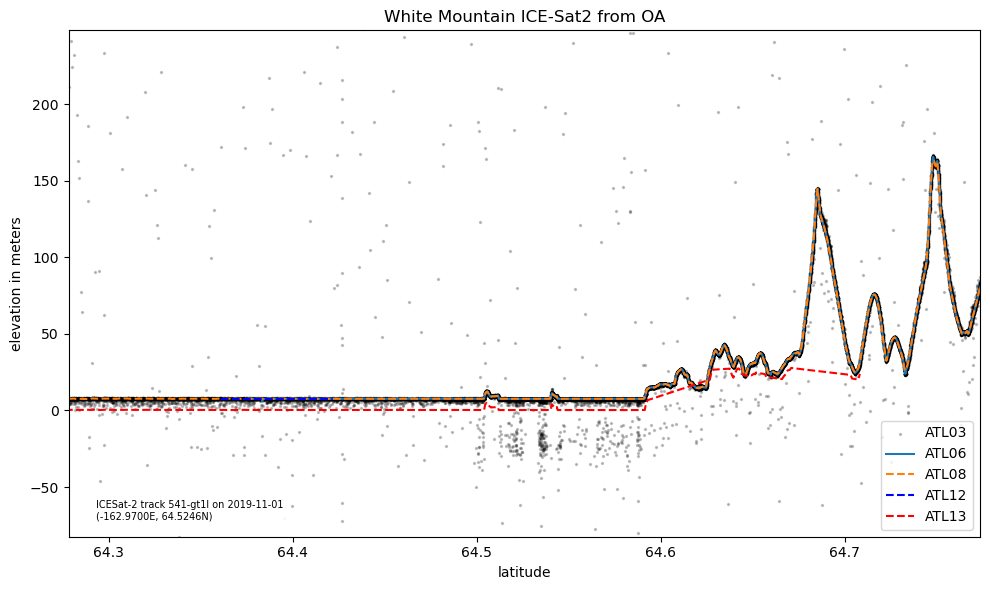

In [9]:
myplot

### Ground Track Stats & Map


In [10]:
lat1, lat2 = mydata.atl08.lat[0], mydata.atl08.lat.iloc[-1]
lon1, lon2 = mydata.atl08.lon[0], mydata.atl08.lon.iloc[-1]

ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)
print('The ground track is about %.1f kilometers long.' % (ground_track_length/1e3))

The ground track is about 55.4 kilometers long.


We want to add this ICESat-2 gound track to our Google Earth Engine map. Let's use the lon/lat coordinates of the ATL08 data product for this.  
We also need to specify which **Coordinate Reference System (CRS)** our data is in. The longitude/latitude system that we are all quite familiar with is referenced by [`EPSG:4326`](https://epsg.io/4326). To add the ground track to the map we need to turn it into an [Earth Engine "Feature Collection"](https://developers.google.com/earth-engine/guides/feature_collections).

In [11]:
ground_track_coordinates = list(zip(mydata.atl08.lon, mydata.atl08.lat))
ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]
gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))

## Create our map with Google Earth Engine

* Set up baselayer with Google Satellite
* Add the topobathy layer
* Add the polygon
* Add the ICESat-2 track

In [13]:
# Baselayer
Map = geemap.Map()
Map.setCenter(-163.0222151036337, 64.58021590637386, zoom=8);
# Add a satellite basemap
Map.add_basemap('SATELLITE') 
Map.layer_opacity(name='Google Satellite', value=0.8)

# Topobathy
# Define our visualization parameters for the DEM collection
vis = {
    'min': -4,
    'max': 130,
    'palette': ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725'], # viridis color palette because I like it :) 
}
Map.addLayer(whiteMtn, vis, 'Topobathy')

# Polygon for region
Map.addLayer(aoi, {}, 'White Mountain, AK')
Map.layer_opacity(name='White Mountain, AK', value=0.6)
Map.add_minimap(zoom=3)

# The ICESat-2 track
Map.addLayer(gtx_feature, {'color': 'red'}, 'ground track')
Map

Map(center=[64.58021590637387, -163.0222151036337], controls=(WidgetControl(options=['position', 'transparent_…

In [80]:
proj = ee.Projection('EPSG:4326');
L8r = mean.reproject(proj, None, 300)

In [84]:
import os
out_shp = os.path.expanduser('./dem.shp')
geemap.extract_values_to_points(gtx_feature, L8r, out_shp)

Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/coastal_topobathy/examples/dem.shp


In [82]:
out_csv = os.path.expanduser('./dem.csv')
geemap.extract_values_to_points(gtx_feature, L8r, out_csv)

Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/coastal_topobathy/examples/dem.csv


In [86]:
Map = geemap.Map()
Map.setCenter(-163.0222151036337, 64.58021590637386, zoom=8);
# Add a satellite basemap
Map.add_basemap('SATELLITE') 
Map.layer_opacity(name='Google Satellite', value=0.8)
countries_shp = 'dem.shp'
countries = geemap.shp_to_ee(countries_shp)
Map.addLayer(countries, {}, 'Countries')
#Map.addLayer(L8r, {}, 'mean')

Map

/srv/conda/envs/notebook/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Map(center=[64.58021590637387, -163.0222151036337], controls=(WidgetControl(options=['position', 'transparent_…

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [40]:
print(whiteMtn.size().getInfo())

456


In [54]:
image = whiteMtn.first()
image = whiteMtn.get(0)

Map = geemap.Map()
Map.setCenter(-163.0222151036337, 64.58021590637386, zoom=8);
#Map.addLayer(image, vis, "First image")
mean = whiteMtn.median()
Map.addLayer(median, vis, "First image")
Map

Map(center=[64.58021590637387, -163.0222151036337], controls=(WidgetControl(options=['position', 'transparent_…

In [55]:
type(mean)

ee.image.Image

ee.computedobject.ComputedObject

In [47]:
image = ee.Image(whiteMtn.get(0))
type(whiteMtn.first())

ee.image.Image

In [43]:
Map = geemap.Map()
Map.setCenter(-163.0222151036337, 64.58021590637386, zoom=8);
for index in range(0, 10):
    image = ee.Image(whiteMtn.get(index))
    layer_name = "Image "
    Map.addLayer(image, vis, layer_name, False)

EEException: Element.get, argument 'property': Invalid type.
Expected type: String.
Actual type: Integer.
Actual value: 0